In [1]:
import matplotlib.pyplot as plt
from ms2pip.ms2pipC import MS2PIP
import os
import re
import pandas as pd
import numpy as np
from scipy.stats import rankdata, scoreatpercentile
from pyteomics import parser, fasta

##### Use the result after spectrumAI as input

In [2]:
input_psm_table = "/mnt/nfs/wangd/project/PXD014145/FDR1/vali_out.tsv"
validate_out = pd.read_table(input_psm_table, header = 0, sep = "\t", index_col=0)

##### Convert the modifications to the format required by ms2pip

In [3]:
#Substitution strategy
def replace_mod(s):
    s = s.replace("UNIMOD:4","Carbamidomethyl").replace("UNIMOD:737","TMT6plex").replace("UNIMOD:35","Oxidation").replace("UNIMOD:1","Acetyl").replace("-","|").replace(",","|")
    return s
def get_nativeID(s):
#     return s.split(" ")[-1] 
    return s.split(":")[1]
#     return int(s.split("=")[-1])-1
validate_out.loc[:,"modifications"] = validate_out.apply(lambda x : replace_mod(x["modifications"]) if type(x["modifications"])==str else "-", axis = 1)
validate_out.loc[:,"spec_id"] = validate_out.apply(lambda x : get_nativeID(x["spectra_ref"]), axis = 1)
# validate_out.loc[:,"spec_id"] = validate_out.apply(lambda x : x["PSM_ID"], axis = 1)

##### The peptides filtered by spectrumAI were removed and divided into canonical and non-canonical

In [4]:
filter_out = validate_out[(validate_out["position"]=="non-canonical") | (validate_out["position"]=="canonical") | (validate_out["flanking_ions_support"] == "YES")]
can = filter_out[filter_out["position"]=="canonical"]
non = filter_out[filter_out["position"]!="canonical"]

##### Select the canonical peptides in 380mzML to see if they conform to the format

In [5]:
can[can["SpecFile"]=="MFA380.mzML"][['spec_id', 'sequence', 'modifications',  'charge','retention_time', 'calc_mass_to_charge','search_engine_score[1]']].rename(columns={'sequence': 'peptide', 'retention_time': 'rt', 'calc_mass_to_charge': 'mz','search_engine_score[1]': 'score'})

,spec_id,peptide,modifications,charge,rt,mz,score
66,controllerType=0 controllerNumber=1 scan=359,TLLPPP,-,2,165.441156,319.199609,0.072869
295,controllerType=0 controllerNumber=1 scan=1218,LLPPPT,-,2,422.726280,319.199609,0.072869
333,controllerType=0 controllerNumber=1 scan=1310,QRDEKDEHGR,0|TMT6plex|5|TMT6plex,4,440.600000,432.735189,0.000077
337,controllerType=0 controllerNumber=1 scan=1314,EHQVVHSGAR,0|TMT6plex,4,441.200000,337.937537,0.000049
362,controllerType=0 controllerNumber=1 scan=1346,SQHSGNAQVTQTK,0|TMT6plex,3,446.000000,538.951425,0.000018
...,...,...,...,...,...,...,...
101728,controllerType=0 controllerNumber=1 scan=26953,YDCGEEILITVLSAMTEEAAVAIK,0|TMT6plex|3|Carbamidomethyl|15|Oxidation|24|T...,4,4374.200000,775.910414,0.000018
101729,controllerType=0 controllerNumber=1 scan=27290,YDCGEEILITVLSAMTEEAAVAIK,0|TMT6plex|3|Carbamidomethyl|15|Oxidation|24|T...,4,4426.100000,775.910414,0.000049
101730,controllerType=0 controllerNumber=1 scan=28248,YDCGEEILITVLSAMTEEAAVAIK,0|TMT6plex|3|Carbamidomethyl|24|TMT6plex,3,4574.400000,1028.879822,0.000049
101731,controllerType=0 controllerNumber=1 scan=20187,YVELFLNSTAGASGGAYEHR,0|TMT6plex,3,3349.600000,791.067518,0.000018


##### Save the peptides in each mzML in its own PEPREC

In [6]:
for i in range(380,392):
    can_peprec = can[can["SpecFile"]=="MFA"+str(i)+".mzML"]
    can_peprec = can_peprec[['spec_id', 'sequence', 'modifications',  'charge','retention_time', 'calc_mass_to_charge','search_engine_score[1]']].rename(columns={'sequence': 'peptide', 'retention_time': 'rt', 'calc_mass_to_charge': 'mz','search_engine_score[1]': 'score'})
    can_peprec.to_csv('/mnt/nfs/wangd/ms2pip/PEPREC/can/'+str(i)+ '_can.peprec', sep=' ', index=False)
    
    non_peprec = non[non["SpecFile"]=="MFA"+str(i)+".mzML"]
    non_peprec = non_peprec[['spec_id', 'sequence', 'modifications',  'charge','retention_time', 'calc_mass_to_charge','search_engine_score[1]']].rename(columns={'sequence': 'peptide', 'retention_time': 'rt', 'calc_mass_to_charge': 'mz','search_engine_score[1]': 'score'})
    non_peprec.to_csv('/mnt/nfs/wangd/ms2pip/PEPREC/non/'+str(i)+ '_non.peprec', sep=' ', index=False)

##### Set the ms2pip parameters, set five modifications, and set the model to HCD2019

In [7]:
params = {
     "ms2pip": {
         "ptm": [
             "Carbamidomethyl,57.021464,opt,C",
             "TMT6plex,229.162932,opt,K",
             "TMT6plex,229.162932,opt,N-term",
             "Oxidation,15.994915,opt,M",
             "Acetyl,42.010565,opt,N-term",
         ],
         "model": "HCD2019",
         "frag_method": "HCD",
         "frag_error": 0.01,
         "out": "csv",
         "sptm": [], "gptm": [],
     }
}

##### Predict the canonical and non-canonical in each mzML file and save them separately

In [8]:
for i in range(380,392):
    ms2pip = MS2PIP("/mnt/nfs/wangd/ms2pip/PEPREC/can/"+str(i)+"_can.peprec", spec_file="/mnt/nfs/wangd/project/PXD014145/MFA"+str(i)+".mzML",params=params, num_cpu=48, compute_correlations=True, output_filename="/mnt/nfs/wangd/ms2pip/PEPREC/can/"+str(i)+"can")
    ms2pip.run()

In [9]:
for i in range(380,392):
    ms2pip = MS2PIP("/mnt/nfs/wangd/ms2pip/PEPREC/non/"+str(i)+"_non.peprec", spec_file="/mnt/nfs/wangd/project/PXD014145/MFA"+str(i)+".mzML",params=params, num_cpu=48, compute_correlations=True, output_filename="/mnt/nfs/wangd/ms2pip/PEPREC/non/"+str(i)+"non")
    ms2pip.run()

*** Error in `/mnt/nfs/wangd/conda/envs/pypgatk/bin/python': munmap_chunk(): invalid pointer: 0x00005599ae3c85a0 ***
======= Backtrace: =========
/lib64/libc.so.6(+0x7ab54)[0x7fa33703eb54]
/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/numpy/core/_multiarray_umath.cpython-37m-x86_64-linux-gnu.so(+0x5c313)[0x7fa311a38313]
/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/numpy/core/_multiarray_umath.cpython-37m-x86_64-linux-gnu.so(+0x601e3)[0x7fa311a3c1e3]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e392)[0x5599aa504392]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e392)[0x5599aa504392]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e8d7)[0x5599aa5048d7]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e8d7)[0x5599aa5048d7]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(_PyEval_EvalFrameDefault+0x49c8)[0x5599aa5c9d58]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(_PyEval_EvalCodeWithName+0x2f9)[0x5599aa50b059]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/

*** Error in `/mnt/nfs/wangd/conda/envs/pypgatk/bin/python': munmap_chunk(): invalid pointer: 0x00005599ae875020 ***
======= Backtrace: =========
/lib64/libc.so.6(+0x7ab54)[0x7fa33703eb54]
/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/numpy/core/_multiarray_umath.cpython-37m-x86_64-linux-gnu.so(+0x5c313)[0x7fa311a38313]
/mnt/nfs/wangd/conda/envs/pypgatk/lib/python3.7/site-packages/numpy/core/_multiarray_umath.cpython-37m-x86_64-linux-gnu.so(+0x601e3)[0x7fa311a3c1e3]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e392)[0x5599aa504392]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e392)[0x5599aa504392]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e8d7)[0x5599aa5048d7]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(+0x10e8d7)[0x5599aa5048d7]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(_PyEval_EvalFrameDefault+0x49c8)[0x5599aa5c9d58]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/python(_PyEval_EvalCodeWithName+0x2f9)[0x5599aa50b059]
/mnt/nfs/wangd/conda/envs/pypgatk/bin/

##### Concat the results of the peptides in each mzML 

In [10]:
results_can = []
for i in range(380,392):
    r = pd.read_csv("/mnt/nfs/wangd/ms2pip/PEPREC/can/"+str(i)+"can_correlations.csv", index_col=0)
    r['percentile'] = rankdata(r.pearsonr) / r.shape[0]
    results_can.append(r)
result_can = pd.concat(results_can)

results_non = []
for i in range(380,392):
    r = pd.read_csv("/mnt/nfs/wangd/ms2pip/PEPREC/non/"+str(i)+"non_correlations.csv", index_col=0)
    r['percentile'] = rankdata(r.pearsonr) / r.shape[0]
    results_non.append(r)
result_non = pd.concat(results_non)

In [11]:
result_can

,spec_id,ion,pearsonr,percentile
0,controllerType=0 controllerNumber=1 scan=10004,B,-0.588259,0.002770
1,controllerType=0 controllerNumber=1 scan=10004,Y,0.520719,0.565367
2,controllerType=0 controllerNumber=1 scan=10014,B,0.883562,0.887436
3,controllerType=0 controllerNumber=1 scan=10014,Y,NaN,0.975681
4,controllerType=0 controllerNumber=1 scan=10015,B,0.314729,0.379681
...,...,...,...,...
17235,controllerType=0 controllerNumber=1 scan=9997,Y,0.383532,0.443097
17236,controllerType=0 controllerNumber=1 scan=9998,B,0.581776,0.609397
17237,controllerType=0 controllerNumber=1 scan=9998,Y,0.914894,0.913457
17238,controllerType=0 controllerNumber=1 scan=9999,B,0.117596,0.185789


In [12]:
result_non

,spec_id,ion,pearsonr,percentile
0,controllerType=0 controllerNumber=1 scan=11491,B,0.842346,0.280769
1,controllerType=0 controllerNumber=1 scan=11491,Y,0.269759,0.150000
2,controllerType=0 controllerNumber=1 scan=11626,B,0.170806,0.123077
3,controllerType=0 controllerNumber=1 scan=11626,Y,-0.011919,0.053846
4,controllerType=0 controllerNumber=1 scan=11763,B,0.400450,0.184615
...,...,...,...,...
191,controllerType=0 controllerNumber=1 scan=9310,Y,0.532833,0.234694
192,controllerType=0 controllerNumber=1 scan=9563,B,0.477616,0.198980
193,controllerType=0 controllerNumber=1 scan=9563,Y,-0.023967,0.025510
194,controllerType=0 controllerNumber=1 scan=9652,B,0.165692,0.096939


##### merge it with the original peptides table with spec_id as the key

In [13]:
df_can = pd.merge(can, result_can, on='spec_id')
df_non = pd.merge(non, result_non, on='spec_id')

In [14]:
df_can

,sequence,PSM_ID,accession,unique,database,database_version,search_engine,search_engine_score[1],modifications,retention_time,...,matched_ions,sum.matchedions.intensity,sum.fragmentions.intensity,maxintensity,average_intensity,median_intensity,spec_id,ion,pearsonr,percentile
0,MGCCGCGSCGCSGG,3,"ENSP00000497463.1_codon_1,altorf_ENST000006493...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,0|Acetyl|3|Carbamidomethyl|4|Carbamidomethyl|6...,66.636102,...,NaN,0.000000e+00,1.530697e+04,904.448975,728.903564,727.917969,controllerType=0 controllerNumber=1 scan=27,B,NaN,0.983388
1,MGCCGCGSCGCSGG,3,"ENSP00000497463.1_codon_1,altorf_ENST000006493...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,0|Acetyl|3|Carbamidomethyl|4|Carbamidomethyl|6...,66.636102,...,NaN,0.000000e+00,1.530697e+04,904.448975,728.903564,727.917969,controllerType=0 controllerNumber=1 scan=27,Y,NaN,0.984520
2,MSNGGLCGK,13,"DECOY_ENSP00000439023.1,DECOY_ENSP00000269162....",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.066823,1|Oxidation|7|Carbamidomethyl|9|TMT6plex,87.800000,...,"b3,y3",2.031274e+03,1.208844e+04,1400.241943,755.527344,685.528076,controllerType=0 controllerNumber=1 scan=99,B,NaN,0.977943
3,MSNGGLCGK,13,"DECOY_ENSP00000439023.1,DECOY_ENSP00000269162....",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.066823,1|Oxidation|7|Carbamidomethyl|9|TMT6plex,87.800000,...,"b3,y3",2.031274e+03,1.208844e+04,1400.241943,755.527344,685.528076,controllerType=0 controllerNumber=1 scan=99,Y,NaN,0.977891
4,KSYFAK,69,altorf_ENST00000338316.9_3_codon_65,1,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.069117,6|TMT6plex,133.400000,...,y4,7.083267e+02,2.136546e+04,6933.134766,1017.403076,615.347717,controllerType=0 controllerNumber=1 scan=247,B,NaN,0.995571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025527,KMKKKK,150700,"ENSP00000244751.2,altorf_ENST00000244751.7_2_c...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,-,849.575100,...,y4,1.771601e+04,5.898693e+06,708445.875000,41540.089844,4265.119141,controllerType=0 controllerNumber=1 scan=3332,Y,NaN,0.973666
1025528,HTGAVLK,150792,"ENSP00000296255.3,altorf_ENST00000296255.8_1_c...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.000193,0|TMT6plex|7|TMT6plex,1122.000000,...,"b1,y1,b2,y2,b3,y3,b4,y4,b5,y5",2.763813e+06,1.035321e+07,869144.812500,73951.500000,24846.453125,controllerType=0 controllerNumber=1 scan=4775,B,0.587064,0.613457
1025529,HTGAVLK,150792,"ENSP00000296255.3,altorf_ENST00000296255.8_1_c...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.000193,0|TMT6plex|7|TMT6plex,1122.000000,...,"b1,y1,b2,y2,b3,y3,b4,y4,b5,y5",2.763813e+06,1.035321e+07,869144.812500,73951.500000,24846.453125,controllerType=0 controllerNumber=1 scan=4775,Y,0.751642,0.770012
1025530,SVSSSSYR,150825,"ENSP00000446007.1,ENSP00000224237.5,altorf_ENS...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.000184,0|TMT6plex,876.900000,...,"y1,b1,y2,b2,b3,y4,b4,b5,y6,b6,y7",3.880131e+04,3.869464e+05,31428.671875,4552.310059,1203.049561,controllerType=0 controllerNumber=1 scan=3497,B,-0.188457,0.041415


In [15]:
df_non

,sequence,PSM_ID,accession,unique,database,database_version,search_engine,search_engine_score[1],modifications,retention_time,...,matched_ions,sum.matchedions.intensity,sum.fragmentions.intensity,maxintensity,average_intensity,median_intensity,spec_id,ion,pearsonr,percentile
0,TRQCFCDGCC,0,DECOY_altorf_ENST00000517392.6_2_codon_218,1,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,4|Carbamidomethyl|6|Carbamidomethyl|9|Carbamid...,68.09748,...,NaN,0.000000,1.543657e+04,825.126465,701.662292,692.244385,controllerType=0 controllerNumber=1 scan=33,B,NaN,0.520833
1,TRQCFCDGCC,0,DECOY_altorf_ENST00000517392.6_2_codon_218,1,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,4|Carbamidomethyl|6|Carbamidomethyl|9|Carbamid...,68.09748,...,NaN,0.000000,1.543657e+04,825.126465,701.662292,692.244385,controllerType=0 controllerNumber=1 scan=33,Y,NaN,0.524306
2,STNYCMEDCGR,11,"DECOY_altorf_ENST00000374135.9_1_codon_11,DECO...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,0|Acetyl|5|Carbamidomethyl|6|Oxidation|9|Carba...,81.81822,...,NaN,0.000000,1.513134e+04,908.813538,756.567017,778.253479,controllerType=0 controllerNumber=1 scan=80,B,NaN,0.996528
3,STNYCMEDCGR,11,"DECOY_altorf_ENST00000374135.9_1_codon_11,DECO...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,0|Acetyl|5|Carbamidomethyl|6|Oxidation|9|Carba...,81.81822,...,NaN,0.000000,1.513134e+04,908.813538,756.567017,778.253479,controllerType=0 controllerNumber=1 scan=80,Y,NaN,1.000000
4,MMSTGQSCADK,12,altorf_ENST00000359345.5_2_codon_15,1,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.069117,1|Oxidation|2|Oxidation|8|Carbamidomethyl,64.60000,...,NaN,0.000000,1.687677e+04,1279.568970,733.772522,690.138916,controllerType=0 controllerNumber=1 scan=20,B,NaN,0.710214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4697,KGFIYCPEYDFTYFYISLEMEMGQK,150683,DECOY_ncRNA_ENST00000572792.1_3_codon_7,1,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,6|Carbamidomethyl,583.51296,...,NaN,0.000000,3.105132e+04,5436.634766,1070.735107,701.698303,controllerType=0 controllerNumber=1 scan=1821,Y,NaN,0.785714
4698,KLLKLLKYLLLYSKK,150698,"ncRNA_ENST00000507245.1_1_codon_6,altorf_ENST0...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,4|TMT6plex|7|TMT6plex|15|TMT6plex,5265.50904,...,y2,990.371155,2.832229e+04,9624.354492,1348.680298,823.159790,controllerType=0 controllerNumber=1 scan=31056,B,NaN,0.387755
4699,KLLKLLKYLLLYSKK,150698,"ncRNA_ENST00000507245.1_1_codon_6,altorf_ENST0...",0,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.072869,4|TMT6plex|7|TMT6plex|15|TMT6plex,5265.50904,...,y2,990.371155,2.832229e+04,9624.354492,1348.680298,823.159790,controllerType=0 controllerNumber=1 scan=31056,Y,NaN,0.382653
4700,FVSSSSSGGYGGGYGGVLTASDGLLAGNEK,150785,P08727,1,PXD014145-A549-complete_decoy,NaN,"[, , OpenMS/ConsensusID_best, 3.0.0-pre-nightl...",0.000018,0|TMT6plex|30|TMT6plex,3818.80000,...,"y1,b1,b2,y2,b3,y3,b4,y4,b5,y5,b6,y6,b7,b8,y7,b...",393463.437500,1.224957e+06,55051.542969,5420.162598,1902.706787,controllerType=0 controllerNumber=1 scan=22259,B,0.474326,0.193878


##### Drawing B and Y ion Pearson histograms of canonical 

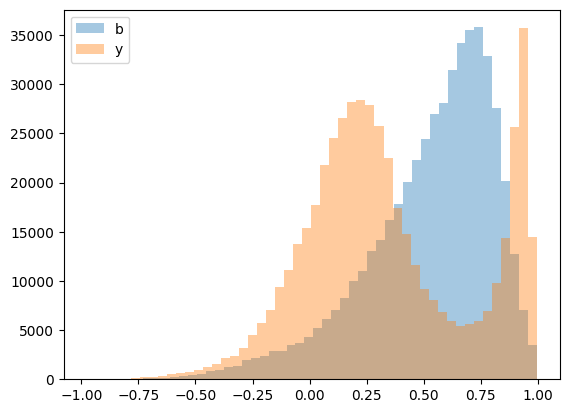

In [16]:
plt.hist(df_can.loc[df_can.ion == 'B', 'pearsonr'], bins=50, alpha=0.4, label='b')
plt.hist(df_can.loc[df_can.ion == 'Y', 'pearsonr'], bins=50, alpha=0.4, label='y')
plt.legend()

##### Drawing B and Y ion Pearson histograms of non-canonical

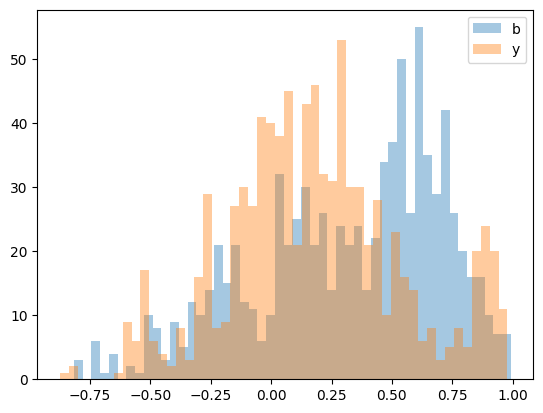

In [17]:
plt.hist(df_non.loc[df_non.ion == 'B', 'pearsonr'], bins=50, alpha=0.4, label='b')
plt.hist(df_non.loc[df_non.ion == 'Y', 'pearsonr'], bins=50, alpha=0.4, label='y')
plt.legend()

##### Draw with 5% of Pearson of canonical as the blue dividing line

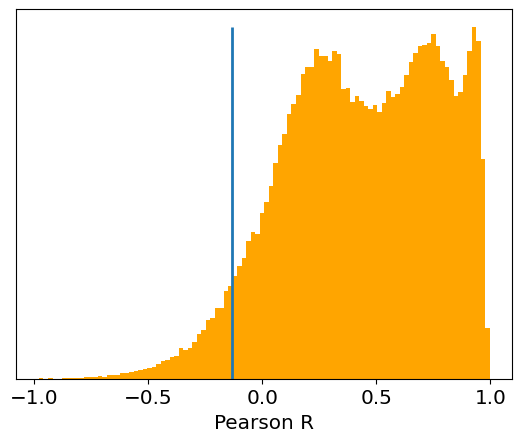

In [18]:
y, x, _ = plt.hist(df_can['pearsonr'], bins=100, color='orange')
plt.vlines(scoreatpercentile(df_can['pearsonr'], 5), 0, y.max(), lw=2)
plt.xlabel('Pearson R', fontsize='x-large')
plt.xticks(np.linspace(-1, 1, 5), fontsize='x-large')
plt.gca().get_yaxis().set_visible(False)

plt.savefig('/mnt/nfs/wangd/ms2pip/PEPREC/can/can_pearsonr_hist.svg')

##### Draw with 5% of Pearson of non-canonical as the blue dividing line

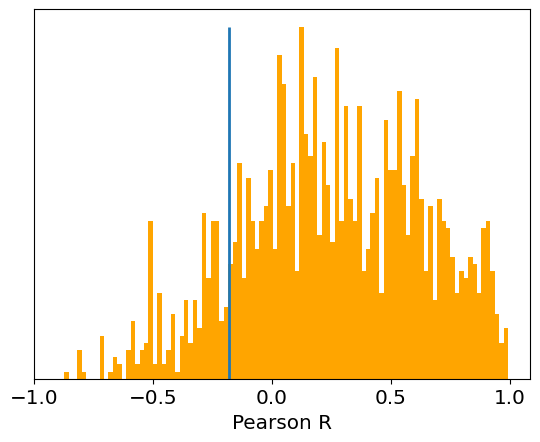

In [19]:
y, x, _ = plt.hist(df_non['pearsonr'], bins=100, color='orange')
plt.vlines(scoreatpercentile(df_non['pearsonr'], 5), 0, y.max(), lw=2)
plt.xlabel('Pearson R', fontsize='x-large')
plt.xticks(np.linspace(-1, 1, 5), fontsize='x-large')
plt.gca().get_yaxis().set_visible(False)

plt.savefig('/mnt/nfs/wangd/ms2pip/PEPREC/can/can_pearsonr_hist.svg')